## Capstone Two -- Black Friday **Company Name** Purchase Prediction

This notebook dives into a dataset that contains purchase information for black friday from **company name** sales. The objective here is to import the data, ensure it is clean and tidy, explore it for any beneficial statistical relationships, perform pre-processing, and then finally create a model that accurately predicts the purchase price. This will inform on future business decisions.

In [2]:
# Importing all necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Data Wrangling

In this phase the data will be imported and checked for accurate definition and fidelity

In [3]:
# Importing train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
# Joining the train and test set to do perfom analysis and feature engineering.
frames = [train, test]
df = pd.concat(frames)

In [5]:
# Getting an idea of what the dataset contains.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
 11  Purchase                    550068 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 77.7+ MB


The missing values in this dataset all occur in the Product_Category 2 and 3 columns. These values will be set to 0 for now. If it is found that the value needs to be changed, that can be done later.

In [6]:
# Checking shape of dataframe and filling all na values with 0
print(df.shape)
df.fillna(0, inplace=True)
df.head()

(783667, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370.0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422.0
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057.0
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969.0


In [7]:
# Checking for any other issues in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          783667 non-null  float64
 10  Product_Category_3          783667 non-null  float64
 11  Purchase                    783667 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 77.7+ MB


#### Exploratory Data Analysis


This section will delve into the nature of the data. Distributions will be analyzed and columns will be explored to futher understand what the data is doing and how it might affect modeling.

In [8]:
# Checking some simple stats on the Purchase(target) column.
df.Purchase.describe()

count    783667.000000
mean       6502.523064
std        5972.146799
min           0.000000
25%           0.000000
50%        6062.000000
75%        9927.000000
max       23961.000000
Name: Purchase, dtype: float64

In [9]:
# Checking the amount of unique values and their counts in the occupation column to determine how to treat it
df['Occupation'].value_counts()

4     103086
0      98850
7      84127
1      67687
17     57418
20     47840
12     44448
14     38782
2      37996
16     36122
6      29102
3      25126
10     18304
5      17373
15     17356
11     16593
19     11919
13     11053
18      9367
9       8929
8       2189
Name: Occupation, dtype: int64

In [10]:
df['Stay_In_Current_City_Years'].value_counts()

1     276425
2     145427
3     135428
4+    120671
0     105716
Name: Stay_In_Current_City_Years, dtype: int64

In [11]:
# Removing the '+' from the stay_in_current_city_years column and converting to numeric
df['Stay_In_Current_City_Years'] = pd.to_numeric(df['Stay_In_Current_City_Years']\
                                                    .str.replace('+', ''))

In [12]:
# checking age column
df.Age.value_counts()

26-35    313015
36-45    156724
18-25    141953
46-50     65278
51-55     54784
55+       30579
0-17      21334
Name: Age, dtype: int64

<AxesSubplot:>

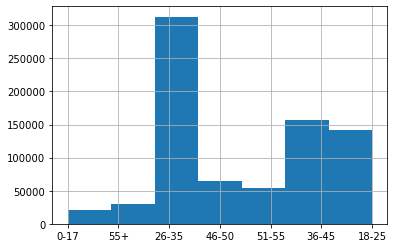

In [13]:
# plotting a distribution of the age column
df.Age.hist(bins=7)

The average purchase price is around 9200. With a min of 12 and a max of 23900

In [14]:
# Removing the ID columns as they are not usefull in predicting the purchase price
df.drop(columns=['Product_ID', 'User_ID'], inplace=True)

array([[<AxesSubplot:title={'center':'Occupation'}>,
        <AxesSubplot:title={'center':'Stay_In_Current_City_Years'}>,
        <AxesSubplot:title={'center':'Marital_Status'}>],
       [<AxesSubplot:title={'center':'Product_Category_1'}>,
        <AxesSubplot:title={'center':'Product_Category_2'}>,
        <AxesSubplot:title={'center':'Product_Category_3'}>],
       [<AxesSubplot:title={'center':'Purchase'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

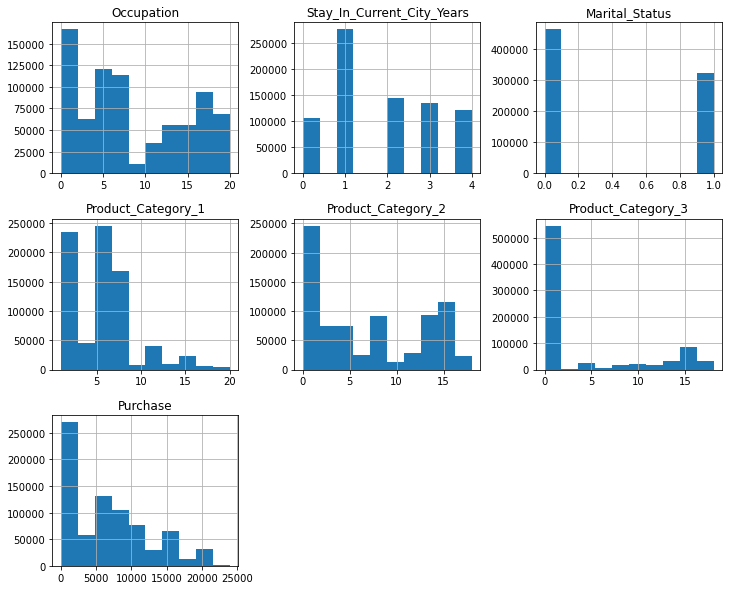

In [15]:
# Checking the distribution on applicable columns
df.hist(figsize=(12,10))

The Purchase column more closely resembles a normal(gaussian) distribution. This is good. But it can be better. Later on all entries in the purchase column equal to 0 will be removed.

<AxesSubplot:xlabel='Age', ylabel='Purchase'>

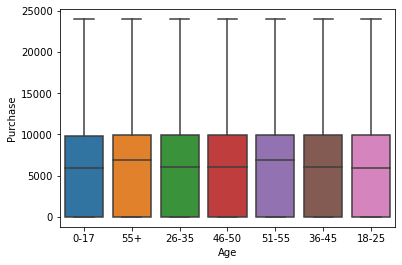

In [16]:
# Checking the distribution of purchase price per age group
sns.boxplot(x='Age', y='Purchase', data=df)

The purchase price is appears to be evenly distributed between all age groups

<AxesSubplot:xlabel='Marital_Status', ylabel='Purchase'>

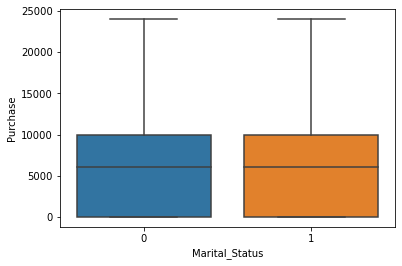

In [17]:
sns.boxplot(x='Marital_Status', y='Purchase', data=df)

Marital status seems to have no effect on purchase price

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

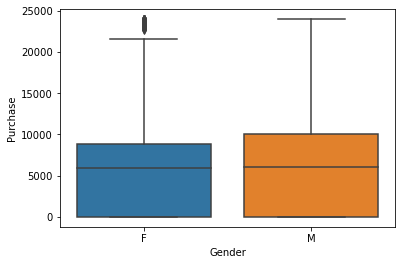

In [18]:
sns.boxplot(x='Gender', y='Purchase', data=df)

A simple observation shows that males spend slightly more than females. This could simply be a quirk of this particular dataset and not representative of the whole.

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

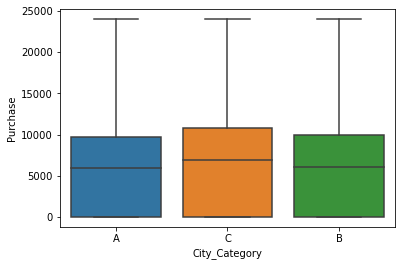

In [19]:
sns.boxplot(x='City_Category', y='Purchase', data=df)

City category C spends slightly more than the other two categories

In [20]:
# Getting the columns for reference
df.columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [21]:
# Making a list of categoricals to generate dummies from.
categoricals = ['Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']

In [22]:
# creating a df with just the categoricals in it
df_cat = df[categoricals]
# creating a df with just numeric values in it
df_num = df.drop(columns=categoricals)
# getting the dummies for the categorical df
df_dummies = pd.get_dummies(df_cat)
# joing the numeric and categorical df now that the encoding is complete
df_enc = pd.concat([df_dummies, df_num], axis=1)
# checking work
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Occupation                  783667 non-null  int64  
 1   Marital_Status              783667 non-null  int64  
 2   Product_Category_1          783667 non-null  int64  
 3   Product_Category_2          783667 non-null  float64
 4   Product_Category_3          783667 non-null  float64
 5   Gender_F                    783667 non-null  uint8  
 6   Gender_M                    783667 non-null  uint8  
 7   Age_0-17                    783667 non-null  uint8  
 8   Age_18-25                   783667 non-null  uint8  
 9   Age_26-35                   783667 non-null  uint8  
 10  Age_36-45                   783667 non-null  uint8  
 11  Age_46-50                   783667 non-null  uint8  
 12  Age_51-55                   783667 non-null  uint8  
 13  Age_55+       

In [23]:
# Ensuring everything is in order
df_enc.head()

,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years,Purchase
0,10,0,3,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,2,8370.0
1,10,0,1,6.0,14.0,1,0,1,0,0,0,0,0,0,1,0,0,2,15200.0
2,10,0,12,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,2,1422.0
3,10,0,12,14.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,2,1057.0
4,16,0,8,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,1,4,7969.0


In [24]:
# Setting features(X) and target(y)
X, y = df_enc.drop(columns='Purchase'), df.Purchase

In [25]:
# Creating first train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Below are some functions that should help speed up the process of modeling

In [26]:
# this function runs a random forest regressor
def model_rndfor(X, y, est, depth, rnd):
    model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=rnd)
    fit_model = model.fit(X, y)
    return fit_model

In [27]:
# ridge regressor
def model_ridge(X, y):
    model = Ridge()
    fit_model = model.fit(X, y)
    return fit_model

In [28]:
# linear regressor
def model_reg(X, y):
    model = LinearRegression()
    fit_model = model.fit(X, y)
    return fit_model

In [29]:
# the following functions score the desired model
def model_score_train(y_train, y_pred):
    mae_train = mean_absolute_error(y_train, y_pred)
    mse_train = mean_squared_error(y_train, y_pred)
    print("Mean Absolute Error of Train Set: " + str(mae_train) + "\n Mean Squared Error of Train Set: " + str(mse_train))
    
def model_score_test(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Absolute Error of Test Set: " + str(mae) + "\n Mean Squared Error of Test Set: " + str(mse))

In [30]:
# trying the first random forest regression model with 100 estimators and a depth of 10
rndfor_fit = model_rndfor(X_test, y_test, 100, 10, 42)
model_score_train(y_train, rndfor_fit.predict(X_train))
model_score_test(y_test, rndfor_fit.predict(X_test))


Mean Absolute Error of Train Set: 4328.583490444691
 Mean Squared Error of Train Set: 27774782.707413517
Mean Absolute Error of Test Set: 4252.549139647958
 Mean Squared Error of Test Set: 26637404.388852246


In [31]:
# fist ridge model for comparison with the random forest model
ridge_fit = model_ridge(X_test, y_test)
model_score_train(y_train, ridge_fit.predict(X_train))
model_score_test(y_test, ridge_fit.predict(X_test))

Mean Absolute Error of Train Set: 4754.922593623172
 Mean Squared Error of Train Set: 33888299.1776002
Mean Absolute Error of Test Set: 4747.915902252476
 Mean Squared Error of Test Set: 33764200.656168014


In [32]:
# a linear regression model as well for comparison
reg_fit = model_reg(X_test, y_test)
model_score_train(y_train, reg_fit.predict(X_train))
model_score_test(y_test, reg_fit.predict(X_test))

Mean Absolute Error of Train Set: 4754.922275164751
 Mean Squared Error of Train Set: 33888298.935023054
Mean Absolute Error of Test Set: 4747.915618764968
 Mean Squared Error of Test Set: 33764200.65597678


The previous models show that random forest is better regarding the mae

Changing the product category columns to categoricals and dummy encoding them for modeling

In [33]:
# changing the column data types
df_cat = df_cat.astype({'Product_Category_1': 'object', 'Product_Category_2': 'object', 'Product_Category_3': 'object'})
# getting the dummies
df_dummies = pd.get_dummies(df_cat)
# concat 
df_enc = pd.concat([df_dummies, df_num], axis=1)
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783667 entries, 0 to 233598
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Occupation                  783667 non-null  int64  
 1   Marital_Status              783667 non-null  int64  
 2   Gender_F                    783667 non-null  uint8  
 3   Gender_M                    783667 non-null  uint8  
 4   Age_0-17                    783667 non-null  uint8  
 5   Age_18-25                   783667 non-null  uint8  
 6   Age_26-35                   783667 non-null  uint8  
 7   Age_36-45                   783667 non-null  uint8  
 8   Age_46-50                   783667 non-null  uint8  
 9   Age_51-55                   783667 non-null  uint8  
 10  Age_55+                     783667 non-null  uint8  
 11  City_Category_A             783667 non-null  uint8  
 12  City_Category_B             783667 non-null  uint8  
 13  City_Category_

In [34]:
# encoded X and y
X1, y1 = df_enc.drop(columns='Purchase'), df.Purchase

In [35]:
# standardizing the X1 df
ss = StandardScaler()
X_stand = ss.fit_transform(X1)

In [36]:
# second train test split. this time using the encoded, standardized data
X1_train, X1_test, y1_train, y1_test = train_test_split(X_stand, y1, test_size=0.2, random_state=42)

In [37]:
# fitting and scoring the same models as before with the newly transformed data
rndfor_fit = model_rndfor(X1_test, y1_test, 100, 10, 42)
print('Random Forest score: ')
model_score_train(y1_train, rndfor_fit.predict(X1_train))
model_score_test(y1_test, rndfor_fit.predict(X1_test))
print('\n')

ridge_fit = model_ridge(X1_test, y1_test)
print('Ridge Regression score: ')
model_score_train(y1_train, ridge_fit.predict(X1_train))
model_score_test(y1_test, ridge_fit.predict(X1_test))
print('\n')

reg_fit = model_reg(X1_test, y1_test)
print('Linear Regression score: ')
model_score_train(y1_train, reg_fit.predict(X1_train))
model_score_test(y1_test, reg_fit.predict(X1_test))

Random Forest score: 
Mean Absolute Error of Train Set: 4386.582575175736
 Mean Squared Error of Train Set: 28159182.951552805
Mean Absolute Error of Test Set: 4316.035773476157
 Mean Squared Error of Test Set: 26916229.400649797


Ridge Regression score: 
Mean Absolute Error of Train Set: 4337.719677963887
 Mean Squared Error of Train Set: 27791203.16558068
Mean Absolute Error of Test Set: 4337.825946907134
 Mean Squared Error of Test Set: 27740571.980420116


Linear Regression score: 
Mean Absolute Error of Train Set: 4338.541660745074
 Mean Squared Error of Train Set: 27792642.386027873
Mean Absolute Error of Test Set: 4338.644853145161
 Mean Squared Error of Test Set: 27741073.366185326


These changes don't seem to have much effect

In [38]:
lsvr = LinearSVR()
lsvr.fit(X1_train, y1_train)
model_score_train(y1_train, lsvr.predict(X1_train))
model_score_test(y1_test, lsvr.predict(X1_test))

Mean Absolute Error of Train Set: 4155.372944012359
 Mean Squared Error of Train Set: 30037767.95300223
Mean Absolute Error of Test Set: 4159.437848755069
 Mean Squared Error of Test Set: 30022183.310531873


So far linearSVR is providing the best mae score

In [39]:
# Gradient boost using the categorical representation of the Product Categories
gbr = GradientBoostingRegressor()
gbr.fit(X1_train, y1_train)
model_score_train(y1_train, gbr.predict(X1_train))
model_score_test(y1_test, gbr.predict(X1_test))

Mean Absolute Error of Train Set: 4362.326120164598
 Mean Squared Error of Train Set: 27865051.45450041
Mean Absolute Error of Test Set: 4364.724009574726
 Mean Squared Error of Test Set: 27845963.444723614


In [40]:
# Gradient boost using the numerical representation of the Product Categories
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
model_score_train(y_train, gbr.predict(X_train))
model_score_test(y_test, gbr.predict(X_test))

Mean Absolute Error of Train Set: 4343.144972007444
 Mean Squared Error of Train Set: 27779070.06322012
Mean Absolute Error of Test Set: 4345.829987303312
 Mean Squared Error of Test Set: 27760419.515125185


Not much to say about the gradient boosting model. There is potential for tuning, so this might get more attention later.

Below the purchase column is getting all entries equal to 0 removed. New X and y variable are prepared with this differing transformation

In [41]:
# removing all rows where purchase is 0
# splitting the features from the target while also standardizing the features
df_no_zeros = df_enc[df_enc['Purchase'] > 0]
X2, y2 = ss.fit_transform(df_no_zeros.drop(columns='Purchase')), df_no_zeros.Purchase

In [42]:
# train test split on the newly configured data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [43]:
# building simple linear svr model on latest data interation
lsvr = LinearSVR(C=2)
lsvr.fit(X2_train, y2_train)
model_score_train(y2_train, lsvr.predict(X2_train))
model_score_test(y2_test, lsvr.predict(X2_test))

Mean Absolute Error of Train Set: 2189.731350506614
 Mean Squared Error of Train Set: 9695848.18780138
Mean Absolute Error of Test Set: 2204.753642676355
 Mean Squared Error of Test Set: 9870118.914288746


So far this LinearSVR model with the purchase column normalized, is the best performing.

### Summary